# Import Data

In [1]:
import numpy as np
from netCDF4 import Dataset
directory="/Users/lambda/Documents/Code/CaliforniaDrought/Data/"
file=directory+"Pressure/slp.mon.mean.nc"
nc=Dataset(file,'r')
pressure=nc.variables["slp"][0:816,0:48,48:112]
#pressure=nc.variables["slp"][0:816,0:28,0:28]
lat=nc.variables["lat"][:]
lon=nc.variables["lon"][:]
from numpy import loadtxt
CAMonthTotal= loadtxt(directory+'Precipitation/CAMonthTotal.txt')
ORMonthTotal= loadtxt(directory+'Precipitation/ORMonthTotal.txt')
WCMonthTotal= loadtxt(directory+'Precipitation/WCMonthTotal.txt')
CAMonthTotal=CAMonthTotal.reshape((816, 1))
ORMonthTotal=ORMonthTotal.reshape((816, 1))
WCMonthTotal=WCMonthTotal.reshape((816, 1))
rlat=48
rlon=64
x_data=pressure.flatten()
x_data=np.reshape((x_data-np.mean(x_data))/np.var(x_data),(816,rlat,rlon,1))
y_data=(CAMonthTotal-np.mean(CAMonthTotal))/np.var(CAMonthTotal)

# Set Computing Graph

### HyperParameters

In [2]:
ptraining=570
ctraining=[]
ctest=[]
#Convolution Layer Parameters
wc1=3
nc1=5
wc2=3
nc2=5
wp1=2
wp2=2
fl=(rlat-wc1-wc2-wp1-wp2+4)*(rlon-wc1-wc2-wp1-wp2+4)*nc2
wfc=50
wfc2=10

### Graph

In [3]:
import tensorflow as tf
tf.reset_default_graph()
x = tf.placeholder('float', [None, rlat,rlon,1])
y = tf.placeholder('float',[None,1])
def convolutional_neural_network(x):
    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='VALID')
    def maxpool2d(x,W):
        return tf.nn.max_pool(x, [1,W,W,1], strides=[1,1,1,1], padding='VALID')
    weights = {'W_conv1':tf.Variable(tf.random_normal([wc1,wc1,1,nc1],stddev=0.001,name="W_conv1")),
               'W_conv2':tf.Variable(tf.random_normal([wc2,wc2,nc1,nc2],stddev=0.001)),
               'W_fc':tf.Variable(tf.random_normal([fl,wfc],stddev=0.001)),
               'W_fc2':tf.Variable(tf.random_normal([wfc,wfc2],stddev=0.001)),
               'out':tf.Variable(tf.random_normal([wfc2, 1],stddev=0.001))}

    biases = { 'b_conv1':tf.Variable(tf.random_normal([nc1],stddev=0.001)),
               'b_conv2':tf.Variable(tf.random_normal([nc2],stddev=0.001)),
               'b_fc':tf.Variable(tf.random_normal([wfc],stddev=0.001)),
               'b_fc2':tf.Variable(tf.random_normal([wfc2],stddev=0.001)),
               'out':tf.Variable(tf.random_normal([1],stddev=0.001))}
    
    
    conv1 = conv2d(x, weights['W_conv1']) + biases['b_conv1']
    pool1 = maxpool2d(conv1,wp1)

    conv2 = conv2d(pool1, weights['W_conv2']) + biases['b_conv2']
    pool2 = maxpool2d(conv2,wp1)

    fc = tf.reshape(pool2,[-1, fl])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc2 = tf.nn.relu(tf.matmul(fc, weights['W_fc2'])+biases['b_fc2'])
    output = tf.matmul(fc2, weights['out'])+biases['out'] 
    return output

In [4]:
prediction = convolutional_neural_network(x)
cost = tf.reduce_mean(tf.square(prediction-y))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)
all_saver = tf.train.Saver()

# Train

In [5]:
def train_neural_network(x):
    batch=100
    epoches=200
    gtestcost=np.inf
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(epoches):
            for b in range(ptraining/batch):
                epoch_x=x_data[b*batch:(b+1)*batch,:,:,:]
                epoch_y=y_data[b*batch:(b+1)*batch,:]
                sess.run(optimizer, feed_dict={x: epoch_x, y: epoch_y})
                trainingcost=sess.run(cost, feed_dict={x: epoch_x, y: epoch_y})
                ctraining.append(trainingcost)
            testcost=sess.run(cost, feed_dict={x: x_data[ptraining:,:,:,:], 
                                                   y: y_data[ptraining:,:]})
            if testcost < gtestcost:
                gtestcost=testcost
                all_saver.save(sess, 'CNN_Trained')
            ctest.append(testcost)
        result=sess.run(prediction,feed_dict={x: x_data})
        sess.close()
    return result 

In [6]:
prediction_batch=train_neural_network(x)

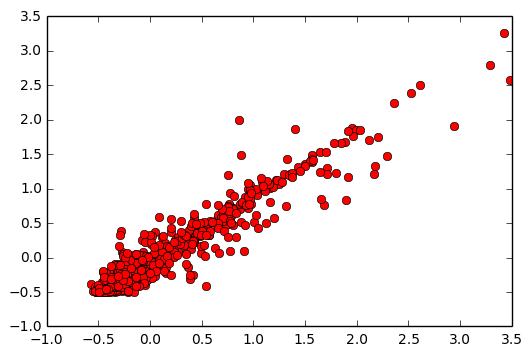

In [7]:
import matplotlib.pyplot as plt
plt.plot(prediction_batch,y_data,'ro')
plt.show()

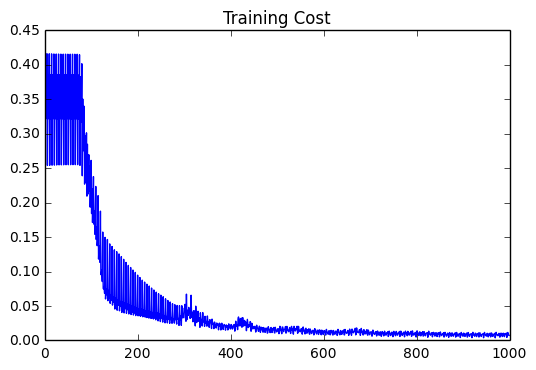

In [8]:
plt.plot(ctraining)
plt.title("Training Cost")
plt.show()

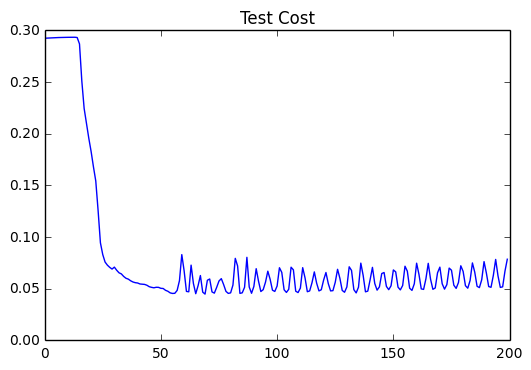

In [9]:
plt.plot(ctest)
plt.title("Test Cost")
plt.show()

# Result

In [10]:
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore model weights from previously saved model
    load_path =all_saver.restore(sess, '/Users/lambda/Documents/Code/Lib/Python/TensorFlow/CNN_Trained')
    trainingresult=sess.run(prediction,feed_dict={x:x_data[1:ptraining,:,:,:]})
    testresult=sess.run(prediction,feed_dict={x:x_data[ptraining+1:,:,:,:]})

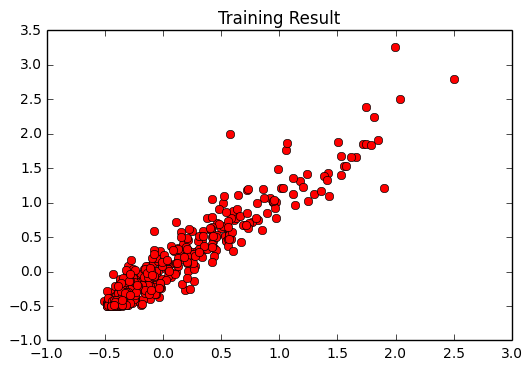

In [11]:
import matplotlib.pyplot as plt
plt.plot(trainingresult,y_data[1:ptraining,:],'ro')
plt.title("Training Result")
plt.show()

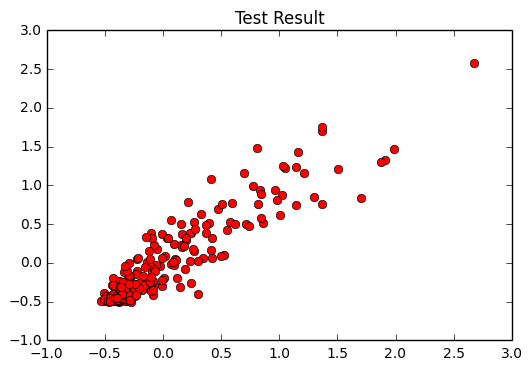

In [12]:
import matplotlib.pyplot as plt
plt.plot(testresult,y_data[ptraining+1:,:],'ro')
plt.title("Test Result")
plt.show()